In [2]:
# Scientific imports

%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# General imports

import csv, math, os, os.path, sys, random
import pandas as pd
import seaborn as sb
from sklearn import metrics
from IPython.display import display

plt.rcParams["figure.figsize"] = (20,9)
sb.set()

In [3]:
# Reading which LC datafiles we have into a list

fitsList = []
fitsroot = "SIM_DATA/"
fits_directories = [x[0] for x in os.walk('./SIM_DATA/.', topdown=True)]

for fitsroot, fits_dirs, fits_files in os.walk(fitsroot):
    for fits_file in fits_files:
        fullpath = os.path.join(fitsroot, fits_file)
        if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
            fitsList.append(fullpath)
print("Number of FITS files: {}".format(len(fitsList)))
#for num, i in enumerate(fitsList):
#    print ("{}: {}".format(num, i))
    
print(len(fitsList))

Number of FITS files: 16000
16000


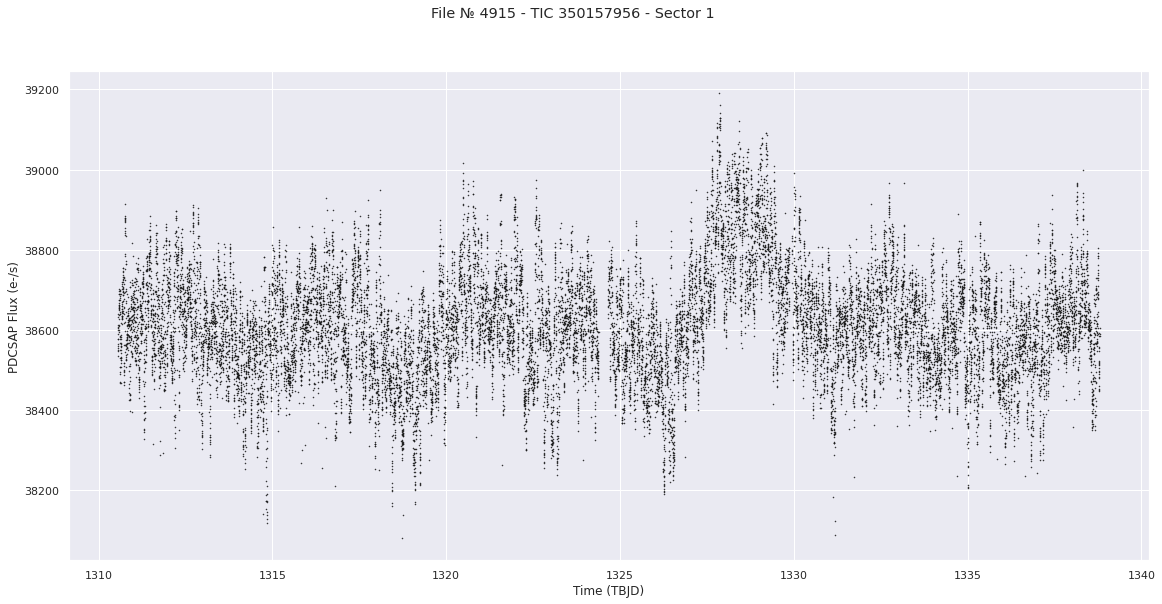

In [12]:
rndFile = random.randint(0,len(fitsList))

#fileNum = fitsList[rndFile]
fitsFile = fitsList[rndFile]
#check = fits.info(file)

# The following line of code gives us the header values
fitsHeaders = fits.getheader(fitsFile)
#fitsHeaders

#fits.getdata(file, ext=1).columns

with fits.open(fitsFile, mode="readonly") as hdulist:
    
    # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
    # and TESS magnitude.
    star_teff = hdulist[0].header['TEFF']
    star_logg = hdulist[0].header['LOGG']
    star_tmag = hdulist[0].header['TESSMAG']
    obj = hdulist[0].header['OBJECT']
    sector = hdulist[0].header['SECTOR']
    
    # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
    # extension.
    #period = hdulist[1].header['TPERIOD']
    #duration = hdulist[1].header['TDUR']
    duration = (hdulist[1].header['LIVETIME'])
    #epoch = hdulist[1].header['TEPOCH']
    #depth = hdulist[1].header['TDEPTH']
    
    # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
    # model fluxes.
    #times = hdulist[1].data['TIME']
    #phases = hdulist[1].data['PHASE']
    #fluxes_init = hdulist[1].data['LC_INIT']
    #model_fluxes_init = hdulist[1].data['MODEL_INIT']
    tess_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    
# Define the epoch of primary transit in TBJD.  Our timestamps are also already in TBJD.
#t0 = 1327.520678

# Start figure and axis.
fig, ax = plt.subplots()

# Plot the timeseries in black circles.
## Using the [1:-1] identifier to cut off the leading and trailing zeroes

ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)

# Center the x-axis on where we expect a transit to be (time = T0), and set
# the x-axis range within +/- 1 day of T0.
########ax.set_xlim(t0 - 1.0, t0 + 1.0)

# Overplot a red vertical line that should be where the transit occurs.
########ax.axvline(x=t0, color="red")

# Let's label the axes and define a title for the figure.
fig.suptitle("File № {} - {} - Sector {}".format(rndFile, str(obj), str(sector))) # + str(obj) + " - Sector " + str(sector))
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")

# Adjust the left margin so the y-axis label shows up.
plt.subplots_adjust(left=0.15)
#plt.figure(figsize=(2,8))
plt.show()

Now we're gonna load the Truth Files, csv-formatted txt files extracted from 'lilith4_sector-1_groundtruth.tar.gz'

In [182]:
# Initialise the identifier list
plist=[]
slist=[]
eblist=[]
beblist=[]

planetlist="tsop301_planet_data.txt"
starlist="tsop301_star_data.txt"
eclipsingbinarylist="tsop301_eb_data.txt"
backeclipsingbinarylist="tsop301_backeb_data.txt"

print('./SIM_DATA/unpacked/{}'.format(planetlist))

./SIM_DATA/unpacked/tsop301_planet_data.txt


In [181]:
# open the file
with open('./SIM_DATA/unpacked/{}'.format(planetlist)) as datafile:
    dr = csv.reader(datafile)
    for lineholder in dr:
        line = lineholder[0]                # I don't know why but this makes it work better
        if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
            plist.append(line.split()[0])       # Add line to list
print (len(plist))

8624


Now that we have the list of (in this case) stars, we can now check to see if out Light Curve Object is a (in this case) star or not!

In [141]:
# Recall that the object name was stored in a var called "obj"
obj


'TIC 350157956'

In [143]:
# Now we can just text split it (since we know all LCs will be in "TIC 0000000..." due to it being from TESS)
testid = obj.split("TIC ")[1]
print(testid)

350157956


In [144]:
print(testid in plist)

True


In [173]:
def isThisA(itemtype,n,l):
    # itemtype = (S)tar, (P)lanet, (E)clipsing (B)inary, or (B)ack (E)clipsing (B)inary
    if itemtype.lower() in ["s", "star"]:
        print((n in l),"IT AM STAR")
    elif itemtype.lower() in ["p", "planet"]:
        print ("IT AM PLANET")
    elif itemtype.lower() in ["eb", "eclipsing binary", "eclipsingbinary"]:
        print ("IT AM ECLIPSING BINARY")
    elif itemtype.lower() in ["beb", "back eclipsing binary", "backeclipsingbinary"]:
        print ("IT AM BACK ECLIPSING BINARY")
    else:
        # If an invalid selection has been entered
        print("You must enter either:\n"
               "* \"S\" (or \"Star\")\n"
               "* \"P\" (or \"Planet\")\n"
               "* \"EB\" (or \"Eclipsing Binary\")\n"
               "* \"BEB\" (or \"Back Eclipsing Binary\")")

In [179]:
# Easier to recall wrapper functions, for quality of life option

def isThisAStar(n,l):
    isThisA("S", n, l)
    
def isThisAPlanet(n,l):
    isThisA("P", n, l)

def isThisAnEclipsingBinary(n,l):
    isThisA("EB", n, l)

def isThisABackEclipsingBinary(n,l):
    isThisA("BEB", n, l)

Now that we've read from one file, we can create new lists for the other ones.  
Please check the next Workbook for completed list generation code.